In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# ! wget https://www.dropbox.com/s/m3fhdaallddln0q/mnist_png_224x3.tar.bz2?dl=0 -O mnist_png_224x3.tar.bz2
# ! tar -jxvf mnist_png_224x3.tar.bz2

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation,Flatten,Dense,Conv2D,Dropout,\
    MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2022-04-13 13:31:31.048832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 13:31:31.048853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
EPOCHS=30
BATCH_SIZE=200
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
train_dir = '/home/a/datasets_all/mnist_png_224x3/training/'
validation_dir = '/home/a/datasets_all/mnist_png_224x3/testing'

# train_dir = 'mnist_png_224x3/training/'
# validation_dir = 'mnist_png_224x3/testing/'

In [6]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = Conv2D(32, (3,3))(inputs)
x = Activation('relu')(x)
x = Conv2D(32, (3,3))(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3))(x)
x = Activation('relu')(x)
x = Conv2D(64, (3,3))(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Dense(10)(x)
x = Activation('softmax')(x)

2022-04-13 13:31:32.698655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-13 13:31:32.698680: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 13:31:32.698697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a): /proc/driver/nvidia/version does not exist
2022-04-13 13:31:32.698852: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model = tf.keras.Model(inputs, x)

In [8]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 220, 220, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                             

In [10]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [11]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=15,
                             width_shift_range=0.2,
                             height_shift_range=0.1,
                             zoom_range=0.1)

In [12]:
train_data = datagen.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                         batch_size=32,   # train_straight: 200
                                         color_mode='rgb'  # баба: class_mode='categorical'
                                         # class_mode='categorical'
                                        ) 

Found 60000 images belonging to 10 classes.


In [13]:
test_data = datagen.flow_from_directory(validation_dir,
                                        target_size=(224,224),
                                        batch_size=32,   # train_straight: 200
                                        color_mode='rgb'
                                        # class_mode='categorical'
                                       )

Found 10000 images belonging to 10 classes.


In [14]:
earlystop = EarlyStopping(monitor='val_loss', # better than val_acc
                          patience=3, 
                          mode='auto', # default
                          verbose=1)

In [15]:
checkpoint = ModelCheckpoint('korea_224_lr-4.h5', 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [17]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data)//BATCH_SIZE, # 300
                    validation_data=test_data,
                    validation_steps=len(test_data)//BATCH_SIZE, # 50
                    epochs=EPOCHS,
                    callbacks=[earlystop, checkpoint, reduce_lr])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 2.2303 - accuracy: 0.2118
Epoch 1: val_loss improved from inf to 2.15118, saving model to korea_224_lr-4.h5
9/9 [==============================] - 22s 2s/step - loss: 2.2303 - accuracy: 0.2118 - val_loss: 2.1512 - val_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.9494 - accuracy: 0.3958
Epoch 2: val_loss improved from 2.15118 to 1.83301, saving model to korea_224_lr-4.h5
9/9 [==============================] - 22s 2s/step - loss: 1.9494 - accuracy: 0.3958 - val_loss: 1.8330 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.8441 - accuracy: 0.4201
Epoch 3: val_loss improved from 1.83301 to 1.74824, saving model to korea_224_lr-4.h5
9/9 [==============================] - 21s 2s/step - loss: 1.8441 - accuracy: 0.4201 - val_loss: 1.7482 - val_accuracy: 0.4062 - lr: 1.0000e-04
Epoch 4/30
9/9 [======================

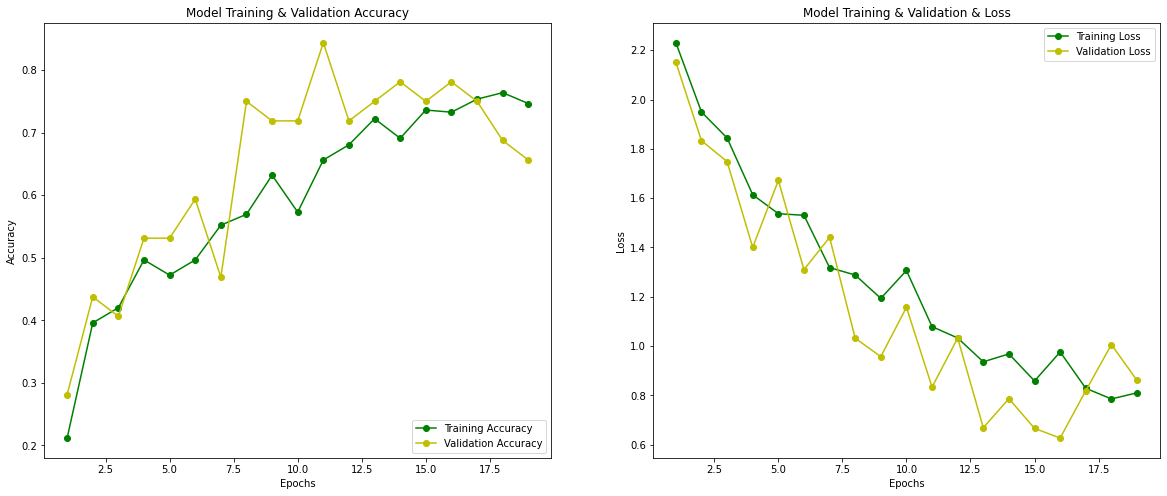

In [18]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()